# RR Lyrae Period-Luminosity

Eric Bellm
January 2020

In this exercise we'll use real data from a variety of surveys to learn more about the relationship between an RR Lyrae variable's period and its luminosity.

In [319]:
%matplotlib inline
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.timeseries import TimeSeries, LombScargle
import matplotlib.pyplot as plt

## Finding the Period of an RR Lyrae star

In [24]:
def load_ztf_lc(filename):
    """Load a ZTF parquet lightcurve saved by `ztf_query`.
    
    See `ZTF_RRLyrae_data.ipynb` for data retrieval.
    
    Parameters
    ----------
    filename : string
        path to a parquet file saved by `ztf_query`
        
    Returns
    -------
    tbl : `astropy.timeseries.TimeSeries`
        lightcurve 
    """
    
    tbl = Table.read(filename)
    
    # exclude flagged data
    tbl = tbl[tbl['catflags'] == 0]
    
    return TimeSeries(time=Time(tbl['hjd'],format='jd'),data=tbl[['mag','magerr','filtercode']])

In [604]:
ts = load_ztf_lc('../data/ztf_rrl_lightcurves/5.parquet')

In [605]:
ts

time,mag,magerr,filtercode
Time,float64,float64,str2
2458230.0001356164,16.9705715,0.0199873261,zg
2458236.931761144,17.4291382,0.0227673724,zg
2458247.9816285064,17.0321426,0.0202377532,zg
2458259.9285070803,16.9848824,0.0200425442,zg
2458261.9639485017,17.370409,0.0222814549,zg
2458262.964103905,17.0384197,0.0202651955,zg
2458262.9650183856,17.0512276,0.0203222986,zg
2458263.9626387847,17.072113,0.0204186831,zg
2458266.982214548,16.9245605,0.0198216625,zg


Which filters are present?

In [606]:
set(ts['filtercode'])

{'zg', 'zi', 'zr'}

In [607]:
def plot_lc(ts):
    """Plot a ZTF lightcurve.
    
    Parameters
    ----------
    ts :  `astropy.timeseries.TimeSeries`
        ZTF lightcurve
        
    """
    
    fig = plt.figure()
    
    
    
    # loop over the available filters
    for filt in set(ts['filtercode']):
        # select the rows that correspond to that filter
        wfilt = ts['filtercode'] == filt
        plt.errorbar(ts[wfilt].time.mjd,ts[wfilt]['mag'],ts[wfilt]['magerr'],
                     label=filt,fmt='.',ls='none')
        
    plt.legend()
    plt.xlabel('MJD (days)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

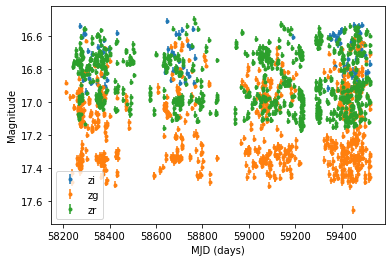

In [608]:
plot_lc(ts)

In [609]:
wr = ts['filtercode'] == 'zr'

In [624]:
ls = LombScargle.from_timeseries(ts[wr],'mag','magerr')#,fit_mean='True',nterms=3)
frequency, power = ls.autopower(method='chi2')

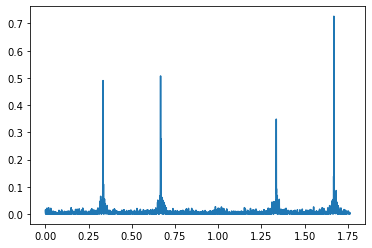

In [625]:
plt.plot(frequency, power) 

In [626]:
ls.false_alarm_probability(power.max(), method='baluev')  

<Quantity 1.25786014e-248>

In [627]:
best_frequency = frequency[np.argmax(power)]
best_period = 1/best_frequency
print(best_period)
#t_fit = np.linspace(ts.time.min(), ts.time.max())
#y_fit = ls.model(t_fit, best_frequency)

0.5990408474257014 d


In [628]:
ts_fold = ts.fold(period=best_period, normalize_phase=True, wrap_phase=1)

In [629]:
def plot_phased_lc(ts):
    """Plot a phase-folded ZTF lightcurve.
    
    Parameters
    ----------
    ts :  `astropy.timeseries.TimeSeries`
        ZTF lightcurve
        
    """
    
    fig = plt.figure()
       
    
    # loop over the available filters
    for filt in set(ts['filtercode']):
        # select the rows that correspond to that filter
        wfilt = ts['filtercode'] == filt
        plt.errorbar(ts[wfilt].time,ts[wfilt]['mag'],ts[wfilt]['magerr'],
                     label=filt,fmt='.',ls='none')
        
    plt.legend()
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

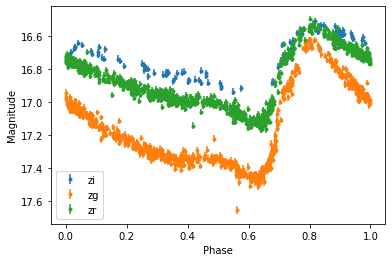

In [630]:
plot_phased_lc(ts_fold)

### Plot Period-Luminosity relation

In [491]:
tbl = Table.read('../data/rrl_main_cat.csv')

In [494]:
tbl.columns

<TableColumns names=('objid','source_id','ra','dec','prob_rrl','best_period','ebv','distance','mean_g','mean_r','mean_i','phot_g_mean_mag','amp_1_r','phi_1_r','amp_1_g','phi_1_g','amp_1_i','phi_1_i','amp_2_r','phi_2_r','amp_2_g','phi_2_g','amp_2_i','phi_2_i','amp_3_r','phi_3_r','amp_3_g','phi_3_g','amp_3_i','phi_3_i','ngooddet_g','ngooddet_r','ngooddet_i')>

In [497]:
tbl

objid,source_id,ra,dec,prob_rrl,best_period,ebv,distance,mean_g,mean_r,mean_i,phot_g_mean_mag,amp_1_r,phi_1_r,amp_1_g,phi_1_g,amp_1_i,phi_1_i,amp_2_r,phi_2_r,amp_2_g,phi_2_g,amp_2_i,phi_2_i,amp_3_r,phi_3_r,amp_3_g,phi_3_g,amp_3_i,phi_3_i,ngooddet_g,ngooddet_r,ngooddet_i
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
245101100001850,2323207596351730304,4.34881002091745,-26.7325358431298,0.95,0.621282,0.0177999,35202.5,18.448895,18.263773,--,18.2781,0.310712,-0.42090702,0.4296189,-0.5540015,--,--,0.13699114,1.1193074,0.18674164,1.1728027,--,--,0.077739686,2.9355524,0.111421965,2.6032557,--,--,74,76,0
245101200001823,2323151181956812672,3.44761987859165,-26.7369695263057,0.89,0.363568,0.0223381,20908.6,17.66247,17.58033,--,17.573,0.21442999,2.6106074,0.31068435,2.6765757,--,--,0.025368612,0.7849637,0.04944191,0.691132,--,--,0.02951918,-1.65067,0.016883053,-1.8536656,--,--,80,81,0
245101200006240,2323082286386272640,3.83587158932291,-27.0437438733329,0.99,0.566281,0.021689,19608.2,17.265985,17.059336,--,17.0437,0.24486491,2.5618405,0.34430373,2.4899223,--,--,0.11433268,0.9279561,0.16546234,1.0097619,--,--,0.08503796,-0.7780889,0.113629706,-0.9787848,--,--,79,79,0
245102200002148,2333889115592815616,1.83508756403094,-26.7386565560488,0.97,0.501806,0.0190932,17462.7,17.080528,16.90064,--,17.0114,0.31278467,3.0024025,0.44559923,2.9263508,--,--,0.1482002,2.0833945,0.21522047,2.0611908,--,--,0.11036861,0.81837624,0.18304227,0.821719,--,--,82,80,0
245103100001517,2333944331692281728,0.885322879300275,-26.5988557305232,0.98,0.58118,0.0158643,13775.1,16.47706,16.245916,--,16.2358,0.18669358,-2.1638775,0.2724687,-2.3415463,--,--,0.09654707,-2.277384,0.12579872,-2.3305018,--,--,0.058639035,-2.5625422,0.07181948,-2.9064033,--,--,82,84,0
245103100002038,2334596681389448192,0.268704425294681,-26.6972408543714,0.79,0.613461,0.015369,59100.4,19.55729,19.410467,--,19.4415,0.27695486,-3.0480475,0.37774724,2.9442918,--,--,0.07293855,1.9353324,0.09814847,2.2232306,--,--,0.10155248,1.5703725,0.056697316,1.1640925,--,--,69,71,0
245103100005002,2334605997174339456,0.513661672542887,-26.4832320691523,0.98,0.564039,0.016883,16770.7,16.92302,16.702965,--,16.7005,0.27261832,-1.16433,0.39498895,-1.2606807,--,--,0.12583855,-0.23147184,0.15405215,-0.18731086,--,--,0.10102296,0.54021835,0.12798515,0.6806197,--,--,82,84,0
245103400002219,2333723948330522496,0.781236701419626,-27.5964286741732,0.62,0.369578,0.0151521,46679.8,19.386032,19.282204,--,19.32,0.20522206,2.1804292,0.28291988,2.1789286,--,--,0.024280133,-0.46539125,0.028752318,-0.023957392,--,--,0.010395379,2.9012606,0.021066511,-0.5510438,--,--,70,70,0
245103400003028,2333530262485132160,0.935840957017628,-27.7687603375627,0.67,0.259518,0.015672,12976.3,16.87104,16.746918,--,16.7321,0.17586449,1.8286661,0.265272,1.7957639,--,--,0.03619911,-0.8076371,0.052383453,-0.7969385,--,--,0.02458537,-3.1161103,0.020252746,-1.4001676,--,--,81,83,0


In [524]:
wgood = tbl['prob_rrl'] > 0.95

In [525]:
tbl['distance_modulus'] = 5*np.log10(tbl['distance']/10.)
A_r = 2.27
tbl['abs_mag_r'] = tbl['mean_r'] - tbl['distance_modulus'] - A_r * tbl['ebv']

In [526]:
def period_luminosity_r(period):
    return -1.6 * np.log10(period/0.6) + 0.51

Text(0, 0.5, 'Absolute Magnitude')

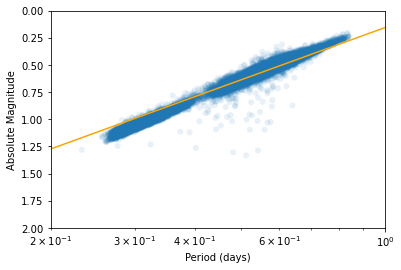

In [532]:
plt.scatter(tbl[wgood]['best_period'],tbl[wgood]['abs_mag_r'],alpha=0.1,edgecolor='none')

ps = np.logspace(-1,1,100)
plt.plot(ps,period_luminosity_r(ps),color='orange')

plt.xscale('log')


plt.ylim(2,0)
plt.xlim(2e-1,1)
plt.xlabel('Period (days)')
plt.ylabel('Absolute Magnitude')

## Estimate distance from the Period-Luminosity relation and compare to the parallax-derived distance.